# Exploration: Embeddings

## Lesson 4 Homework Assignment

MovieLens dataset: https://grouplens.org/datasets/movielens/

In [1]:
import os
current_dir = os.getcwd()

LESSON_HOME_DIR = current_dir + '/'
DATA_HOME_DIR = LESSON_HOME_DIR + 'data/'

#DATASET_DIR = DATA_HOME_DIR + 'ml-20m/'
DATASET_DIR = DATA_HOME_DIR + 'ml-small/'
MODEL_DIR = DATASET_DIR + 'models/'

In [2]:
if not os.path.exists(DATASET_DIR):
    %cd $DATA_HOME_DIR
    #!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
    #!unzip ml-20m.zip
    !wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
    !unzip ml-latest-small.zip && mv ml-latest-small ml-small

In [3]:
if not os.path.exists(MODEL_DIR): os.mkdir(MODEL_DIR)

## Data Setup

In [4]:
import pandas as pd
import numpy as np

In [5]:
ratings = pd.read_csv(DATASET_DIR+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Movie names for a more user-friendly display

In [7]:
movie_names = pd.read_csv(DATASET_DIR+'movies.csv').set_index('movieId')['title'].to_dict()

In [8]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

Update movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())

user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

n_users, n_movies

(671, 9066)

Set the number of latent factors in each embedding.

In [12]:
n_factors = 50

Slick way to randomly split data into training and validation.

In [13]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

In [14]:
len(trn), len(val)

(79677, 20327)

In [15]:
batch_size=64

## Dot Product Model

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [16]:
from keras.layers import Input, Embedding, merge
from keras.layers.core import Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [17]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [18]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [19]:
user_in, user_embed = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, movie_embed = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [20]:
x = merge([user_embed, movie_embed], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [22]:
model.optimizer.lr.get_value().item()

0.0010000000474974513

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/1
79677/79677 [==============================] - 9s - loss: 9.9299 - val_loss: 3.9032


Let's track predictions as we train.

In [24]:
def get_prediction(m, user_id=3, movie_id=6):
    return np.squeeze(m.predict([np.array([user_id]), np.array([movie_id])])).item()

In [25]:
predictions = []

In [26]:
predictions.append(get_prediction(model))
predictions

[3.2230193614959717]

In [27]:
model.optimizer.lr=0.01

In [28]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/3
79677/79677 [==============================] - 9s - loss: 3.1469 - val_loss: 2.0333
Epoch 2/3
79677/79677 [==============================] - 9s - loss: 2.3936 - val_loss: 1.6579
Epoch 3/3
79677/79677 [==============================] - 9s - loss: 2.2151 - val_loss: 1.5275


In [29]:
predictions.append(get_prediction(model))
predictions

[3.2230193614959717, 4.839398384094238]

In [30]:
model.optimizer.lr=0.001

In [31]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/6
79677/79677 [==============================] - 9s - loss: 2.1489 - val_loss: 1.4765
Epoch 2/6
79677/79677 [==============================] - 9s - loss: 2.1133 - val_loss: 1.4590
Epoch 3/6
79677/79677 [==============================] - 9s - loss: 2.0914 - val_loss: 1.4584
Epoch 4/6
79677/79677 [==============================] - 9s - loss: 2.0713 - val_loss: 1.4526
Epoch 5/6
79677/79677 [==============================] - 9s - loss: 2.0565 - val_loss: 1.4499
Epoch 6/6
79677/79677 [==============================] - 9s - loss: 2.0406 - val_loss: 1.4524


In [32]:
predictions.append(get_prediction(model))
predictions

[3.2230193614959717, 4.839398384094238, 5.022331714630127]

According to the course, the best benchmarks for `loss` are a bit over `0.9`, so this model doesn't seem to be working that well...

### Adding Bias

Bias represents how positive or negative each user is, and how good each movie is.

In [33]:
user_in, user_embed = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, movie_embed = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [34]:
user_bias = create_bias(user_in, n_users)
movie_bias = create_bias(movie_in, n_movies)

In [35]:
x = merge([user_embed, movie_embed], mode='dot')
x = Flatten()(x)
x = merge([x, user_bias], mode='sum')
x = merge([x, movie_bias], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/1
79677/79677 [==============================] - 7s - loss: 8.7566 - val_loss: 3.1090


In [38]:
predictions = []

In [39]:
predictions.append(get_prediction(model))
predictions

[3.0250935554504395]

In [40]:
model.optimizer.lr=0.01

In [41]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/3
79677/79677 [==============================] - 7s - loss: 2.5762 - val_loss: 1.6418
Epoch 2/3
79677/79677 [==============================] - 7s - loss: 1.9936 - val_loss: 1.3493
Epoch 3/3
79677/79677 [==============================] - 7s - loss: 1.8362 - val_loss: 1.2368


In [42]:
predictions.append(get_prediction(model))
predictions

[3.0250935554504395, 4.222591876983643]

In [43]:
model.optimizer.lr=0.001

In [44]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/6
79677/79677 [==============================] - 7s - loss: 1.7440 - val_loss: 1.1761
Epoch 2/6
79677/79677 [==============================] - 7s - loss: 1.6666 - val_loss: 1.1389
Epoch 3/6
79677/79677 [==============================] - 7s - loss: 1.5935 - val_loss: 1.1127
Epoch 4/6
79677/79677 [==============================] - 7s - loss: 1.5227 - val_loss: 1.0798
Epoch 5/6
79677/79677 [==============================] - 7s - loss: 1.4527 - val_loss: 1.0504
Epoch 6/6
79677/79677 [==============================] - 7s - loss: 1.3828 - val_loss: 1.0277


In [45]:
predictions.append(get_prediction(model))
predictions

[3.0250935554504395, 4.222591876983643, 5.181187629699707]

Loss is significally lower after equivalent epochs cycle from before. So let's keep training!

In [46]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/10
79677/79677 [==============================] - 7s - loss: 1.3152 - val_loss: 1.0084
Epoch 2/10
79677/79677 [==============================] - 7s - loss: 1.2506 - val_loss: 0.9804
Epoch 3/10
79677/79677 [==============================] - 7s - loss: 1.1871 - val_loss: 0.9639
Epoch 4/10
79677/79677 [==============================] - 7s - loss: 1.1293 - val_loss: 0.9466
Epoch 5/10
79677/79677 [==============================] - 7s - loss: 1.0737 - val_loss: 0.9228
Epoch 6/10
79677/79677 [==============================] - 7s - loss: 1.0204 - val_loss: 0.9080
Epoch 7/10
79677/79677 [==============================] - 7s - loss: 0.9710 - val_loss: 0.8913
Epoch 8/10
79677/79677 [==============================] - 7s - loss: 0.9238 - val_loss: 0.8763
Epoch 9/10
79677/79677 [==============================] - 7s - loss: 0.8799 - val_loss: 0.8602
Epoch 10/10
79677/79677 [==============================] - 7s - loss: 0.8398 - val_loss: 0.8519

In [47]:
predictions.append(get_prediction(model))
predictions

[3.0250935554504395, 4.222591876983643, 5.181187629699707, 4.891323566436768]

In [48]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/5
79677/79677 [==============================] - 7s - loss: 0.8024 - val_loss: 0.8404
Epoch 2/5
79677/79677 [==============================] - 7s - loss: 0.7675 - val_loss: 0.8331
Epoch 3/5
79677/79677 [==============================] - 7s - loss: 0.7368 - val_loss: 0.8250
Epoch 4/5
79677/79677 [==============================] - 7s - loss: 0.7077 - val_loss: 0.8175
Epoch 5/5
79677/79677 [==============================] - 7s - loss: 0.6822 - val_loss: 0.8097


In [49]:
predictions.append(get_prediction(model))
predictions

[3.0250935554504395,
 4.222591876983643,
 5.181187629699707,
 4.891323566436768,
 4.882113933563232]

Loss is now quite a bit better than the `0.9` benchmark. We're still underfitting by quite a lot, however.

Interesting that the rating prediction went above `5` after some epoch sets.

In [50]:
if not os.path.exists(MODEL_DIR + 'bias.h5'):
    model.save_weights(MODEL_DIR + 'bias.h5')
model.load_weights(MODEL_DIR + 'bias.h5')

## Deep Neural Network Model

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [51]:
from keras.layers.core import Dense, Dropout

In [52]:
user_in, user_embed = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, movie_embed = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [53]:
x = merge([user_embed, movie_embed], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [54]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

Run the same initial epoch cycle again...

In [55]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/1
79677/79677 [==============================] - 9s - loss: 2.3859 - val_loss: 0.9071


In [56]:
predictions = []

In [57]:
predictions.append(get_prediction(nn))
predictions

[4.209171772003174]

In [58]:
nn.optimizer.lr=0.01

In [59]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/3
79677/79677 [==============================] - 9s - loss: 1.4465 - val_loss: 0.8737
Epoch 2/3
79677/79677 [==============================] - 9s - loss: 1.2129 - val_loss: 0.8351
Epoch 3/3
79677/79677 [==============================] - 9s - loss: 1.0323 - val_loss: 0.8166


In [60]:
predictions.append(get_prediction(nn))
predictions

[4.209171772003174, 4.260769844055176]

In [61]:
nn.optimizer.lr=0.001

In [62]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79677 samples, validate on 20327 samples
Epoch 1/6
79677/79677 [==============================] - 9s - loss: 0.9179 - val_loss: 0.8089
Epoch 2/6
79677/79677 [==============================] - 9s - loss: 0.8444 - val_loss: 0.8009
Epoch 3/6
79677/79677 [==============================] - 9s - loss: 0.8151 - val_loss: 0.7925
Epoch 4/6
79677/79677 [==============================] - 9s - loss: 0.7999 - val_loss: 0.7940
Epoch 5/6
79677/79677 [==============================] - 9s - loss: 0.7959 - val_loss: 0.7900
Epoch 6/6
79677/79677 [==============================] - 9s - loss: 0.7954 - val_loss: 0.7922


In [63]:
predictions.append(get_prediction(nn))
predictions

[4.209171772003174, 4.260769844055176, 4.450360298156738]

Again a respectable loss, but now we're no longer underfitting (or overfitting!). Also note that we arrive at an 4+ rating prediction after the very first iteration (took more epochs with the dot product models).

## Latent Factor Analysis

In [64]:
counts = ratings.groupby('movieId')['rating'].count()
topMovies = counts.sort_values(ascending=False)
topMovies = np.array(topMovies.index)

In [65]:
# arbitrary indices from counting movies with the most ratings
topMovies[:10]

array([ 57,  49,  99,  92, 143,  72, 402, 417,  79,  89])

In [66]:
# MovieLens indices
[movies[topMovies[i]] for i in range(10)]

[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]

In [67]:
# Movie names
[movie_names[movies[topMovies[i]]] for i in range(10)]

['Forrest Gump (1994)',
 'Pulp Fiction (1994)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Jurassic Park (1993)',
 'Matrix, The (1999)',
 'Toy Story (1995)',
 "Schindler's List (1993)",
 'Terminator 2: Judgment Day (1991)']

We'll look at the movie embeddings. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie's embedding (an array of 50 latent factors).

In [68]:
get_movie_emb = Model(movie_in, movie_embed)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(9066, 50)

Because it's hard to interpret 50 latent factors, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to perform dimensionality reduction.

### Eigenvalues and Explained Variance

We're going to use the _eigenvalues_ of the movie embeddings matrix to determine how much _explained variance_ to attribute to each principal component, 1 to 50.

In [69]:
cor_mat = np.corrcoef(movie_emb.T)

In [70]:
eig_vals, _ = np.linalg.eig(cor_mat)

In [71]:
eig_vals = [np.abs(eig_vals[i]) for i in range(len(eig_vals))]
eig_vals.sort()
eig_vals.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_vals[:10]:
    print(i)
print('...')

Eigenvalues in descending order:
15.273326185
6.44569814969
1.85618263162
1.59242202177
1.47978808727
1.35281465374
1.18230897738
1.07568724066
1.06725706523
0.952990385138
...


In [72]:
p_range = 10

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print('(component n, % explained variance, total % explained variance)')
zip(range(1, p_range+1), var_exp[:p_range], cum_var_exp[:p_range])

(component n, % explained variance, total % explained variance)


[(1, 30.546652370097394, 30.546652370097394),
 (2, 12.891396299370831, 43.438048669468223),
 (3, 3.7123652632492044, 47.150413932717427),
 (4, 3.1848440435376246, 50.33525797625505),
 (5, 2.9595761745441207, 53.294834150799169),
 (6, 2.7056293074817352, 56.000463458280905),
 (7, 2.364617954758625, 58.365081413039533),
 (8, 2.1513744813197286, 60.516455894359261),
 (9, 2.1345141304699324, 62.650970024829192),
 (10, 1.9059807702765279, 64.55695079510572)]

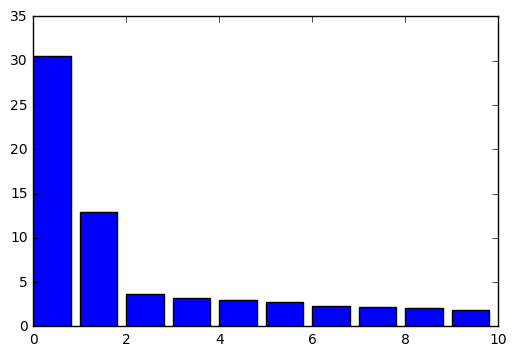

In [73]:
import matplotlib.pyplot as plt

x = range(p_range)
plt.bar(x, var_exp[:p_range])
plt.show()

It looks like the first 2 components, which explain 44.7% of the variance, contribute the biggest blocks of variance. So we will perform PCA on the first 2 components.

### PCA

In [74]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [75]:
pca = PCA(n_components=2)
movie_pca = pca.fit(movie_emb.T).components_

The first component seems to be on a scale from 'critically acclaimed' to 'critically panned'.

In [76]:
fac1 = movie_pca[0]
movie_comp1 = [(movie_names[movies[i]], i, f) for f,i in zip(fac1, topMovies)]

In [77]:
X = sorted(movie_comp1, key=itemgetter(2))[:10]

In [78]:
X.extend(sorted(movie_comp1, key=itemgetter(2), reverse=True)[:10])

In [79]:
X

[('Godfather, The (1972)', 157, -0.037743893),
 ('Fargo (1996)', 505, -0.034468345),
 ('Pulp Fiction (1994)', 49, -0.03241086),
 ('Shawshank Redemption, The (1994)', 99, -0.032098692),
 ('Usual Suspects, The (1995)', 24, -0.031711616),
 ("Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)",
  4722,
  -0.031165753),
 ('Maltese Falcon, The (1941)', 160, -0.031011226),
 ('Rear Window (1954)', 732, -0.030745067),
 ('Chinatown (1974)', 782, -0.029976511),
 ('Godfather: Part II, The (1974)', 328, -0.029193817),
 ('In the Army Now (1994)', 5525, 0.039005142),
 ('Mighty Morphin Power Rangers: The Movie (1995)', 2234, 0.038814042),
 ('Driven (2001)', 4799, 0.038243134),
 ('Dumb and Dumberer: When Harry Met Lloyd (2003)', 4258, 0.037021622),
 ('Rage: Carrie 2, The (1999)', 4420, 0.036865652),
 ('Avengers, The (1998)', 3128, 0.036792148),
 ('Vampires Suck (2010)', 4840, 0.03577242),
 ('Super Mario Bros. (1993)', 4210, 0.035460759),
 ('Dungeons & Dragons (2000)', 4970, 0.035145737),
 ("Joe

The second compenent is less interpretable to me... perhaps 'degree of realism'?

In [80]:
fac2 = movie_pca[1]
movie_comp2 = [(movie_names[movies[i]], i, f) for f,i in zip(fac2, topMovies)]

In [81]:
Y = sorted(movie_comp2, key=itemgetter(2))[:10]

In [82]:
Y.extend(sorted(movie_comp2, key=itemgetter(2), reverse=True)[:10])

In [83]:
Y

[("Singin' in the Rain (1952)", 731, -0.045122568),
 ('Dungeons & Dragons (2000)', 4970, -0.042963095),
 ('Grand Illusion (La grande illusion) (1937)', 993, -0.042327192),
 ('Name of the Rose, The (Name der Rose, Der) (1986)', 275, -0.041264769),
 ('Lawrence of Arabia (1962)', 388, -0.04075215),
 ('Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  180,
  -0.039293569),
 ('Inside Out (2015)', 1888, -0.037287321),
 ('Drive Me Crazy (1999)', 2962, -0.037248246),
 ('Last Detail, The (1973)', 4564, -0.03654094),
 ('Treasure of the Sierra Madre, The (1948)', 783, -0.036478426),
 ('Bowfinger (1999)', 285, 0.05757463),
 ('Arachnophobia (1990)', 282, 0.055903971),
 ('Lawnmower Man, The (1992)', 3064, 0.050934341),
 ('Eyes Wide Shut (1999)', 948, 0.048820503),
 ('Karate Kid, The (1984)', 2622, 0.048644394),
 ('Pacific Rim (2013)', 1782, 0.047789581),
 ('Prophecy, The (1995)', 3053, 0.04756454),
 ('Cocoon (1985)', 915, 0.0459214),
 ('Virgin Suicides, The (1999)', 

Let's map these components on a plot! First, we'll make sure every movie is included in both `X` and `Y`.

In [84]:
df_1 = pd.DataFrame(movie_comp1)
df_1.columns = ['movie_name', 'popularity_id', 'factor']
df_1[:10]

,movie_name,popularity_id,factor
0,Forrest Gump (1994),57,-0.015161
1,Pulp Fiction (1994),49,-0.032411
2,"Shawshank Redemption, The (1994)",99,-0.032099
3,"Silence of the Lambs, The (1991)",92,-0.027154
4,Star Wars: Episode IV - A New Hope (1977),143,-0.021088
5,Jurassic Park (1993),72,-0.013260
6,"Matrix, The (1999)",402,-0.022995
7,Toy Story (1995),417,-0.013945
8,Schindler's List (1993),79,-0.027549
9,Terminator 2: Judgment Day (1991),89,-0.018253


In [85]:
df_2 = pd.DataFrame(movie_comp2)
df_2.columns = ['movie_name', 'popularity_id', 'factor']
df_2[:10]

,movie_name,popularity_id,factor
0,Forrest Gump (1994),57,-0.018733
1,Pulp Fiction (1994),49,-0.009530
2,"Shawshank Redemption, The (1994)",99,-0.024113
3,"Silence of the Lambs, The (1991)",92,0.003176
4,Star Wars: Episode IV - A New Hope (1977),143,-0.018065
5,Jurassic Park (1993),72,-0.002391
6,"Matrix, The (1999)",402,-0.018365
7,Toy Story (1995),417,-0.011479
8,Schindler's List (1993),79,-0.026204
9,Terminator 2: Judgment Day (1991),89,-0.017950


In [86]:
df_X = pd.DataFrame(X)
df_X.columns = ['movie_name', 'popularity_id', 'factor']
df_X

,movie_name,popularity_id,factor
0,"Godfather, The (1972)",157,-0.037744
1,Fargo (1996),505,-0.034468
2,Pulp Fiction (1994),49,-0.032411
3,"Shawshank Redemption, The (1994)",99,-0.032099
4,"Usual Suspects, The (1995)",24,-0.031712
5,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,4722,-0.031166
6,"Maltese Falcon, The (1941)",160,-0.031011
7,Rear Window (1954),732,-0.030745
8,Chinatown (1974),782,-0.029977
9,"Godfather: Part II, The (1974)",328,-0.029194


In [87]:
df_Y = pd.DataFrame(Y)
df_Y.columns = ['movie_name', 'popularity_id', 'factor']
df_Y

,movie_name,popularity_id,factor
0,Singin' in the Rain (1952),731,-0.045123
1,Dungeons & Dragons (2000),4970,-0.042963
2,Grand Illusion (La grande illusion) (1937),993,-0.042327
3,"Name of the Rose, The (Name der Rose, Der) (1986)",275,-0.041265
4,Lawrence of Arabia (1962),388,-0.040752
5,Raiders of the Lost Ark (Indiana Jones and the...,180,-0.039294
6,Inside Out (2015),1888,-0.037287
7,Drive Me Crazy (1999),2962,-0.037248
8,"Last Detail, The (1973)",4564,-0.036541
9,"Treasure of the Sierra Madre, The (1948)",783,-0.036478


In [88]:
def reconcile_movies(source_df, target_df, target_all):
    for i, row in source_df.iterrows():
        # check if movie is missing target_df
        if np.where(target_df.popularity_id != row.popularity_id):
            # append to target_df the missing target value from target_all that matches the row popularity_id
            missing = target_all.loc[np.where(target_all.popularity_id == row.popularity_id)[0][0]]
            target_df = target_df.append(missing)
    target_df = target_df.reset_index()
    return target_df

In [89]:
df_Yr = reconcile_movies(df_X, df_Y, df_2)
df_Yr

,index,movie_name,popularity_id,factor
0,0,Singin' in the Rain (1952),731,-0.045123
1,1,Dungeons & Dragons (2000),4970,-0.042963
2,2,Grand Illusion (La grande illusion) (1937),993,-0.042327
3,3,"Name of the Rose, The (Name der Rose, Der) (1986)",275,-0.041265
4,4,Lawrence of Arabia (1962),388,-0.040752
5,5,Raiders of the Lost Ark (Indiana Jones and the...,180,-0.039294
6,6,Inside Out (2015),1888,-0.037287
7,7,Drive Me Crazy (1999),2962,-0.037248
8,8,"Last Detail, The (1973)",4564,-0.036541
9,9,"Treasure of the Sierra Madre, The (1948)",783,-0.036478


In [90]:
df_Xr = reconcile_movies(df_Y, df_X, df_1)
df_Xr

,index,movie_name,popularity_id,factor
0,0,"Godfather, The (1972)",157,-0.037744
1,1,Fargo (1996),505,-0.034468
2,2,Pulp Fiction (1994),49,-0.032411
3,3,"Shawshank Redemption, The (1994)",99,-0.032099
4,4,"Usual Suspects, The (1995)",24,-0.031712
5,5,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,4722,-0.031166
6,6,"Maltese Falcon, The (1941)",160,-0.031011
7,7,Rear Window (1954),732,-0.030745
8,8,Chinatown (1974),782,-0.029977
9,9,"Godfather: Part II, The (1974)",328,-0.029194


In [91]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

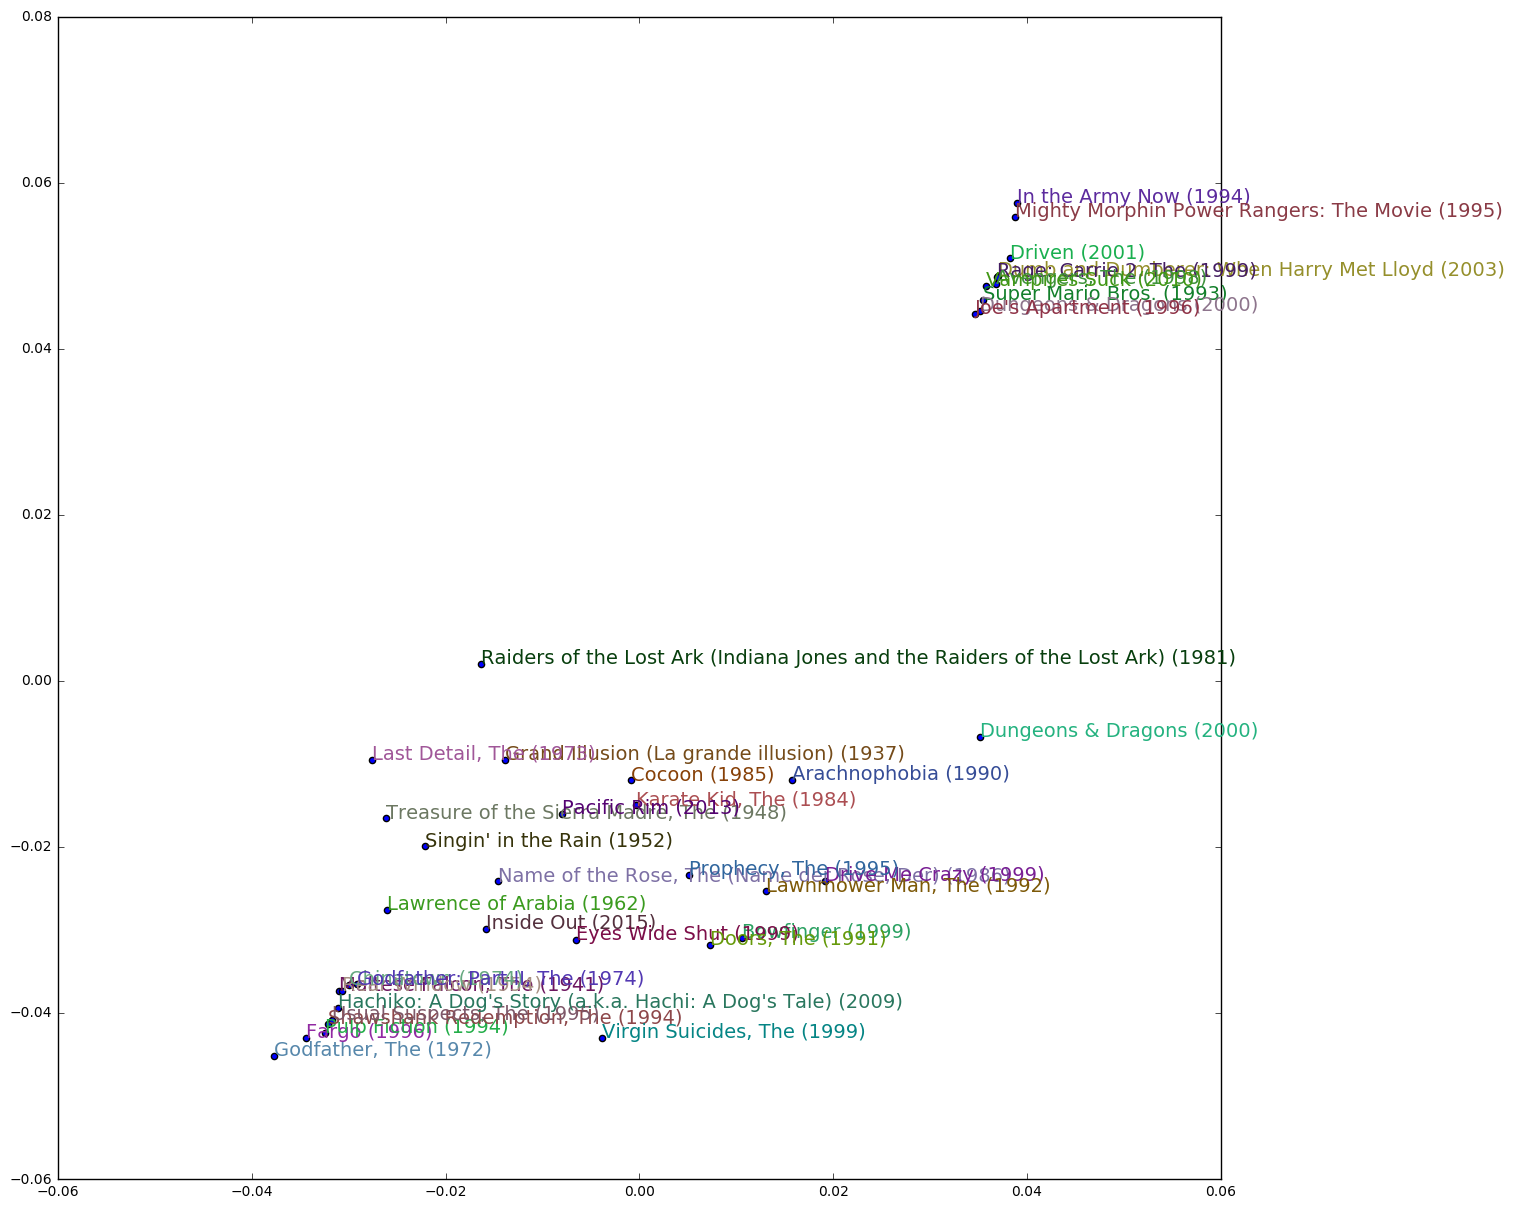

In [92]:
X_plot = [x.factor for i, x in df_Xr.iterrows()]
Y_plot = [y.factor for i, y in df_Yr.iterrows()]

plt.figure(figsize=(15,15))
plt.scatter(X_plot, Y_plot)
for i, x, y in zip(df_Xr.popularity_id, X_plot, Y_plot):
    plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

There are two interesting-ly tight clusters on the poles of the regression line for this plot. Let's try to zoom in.

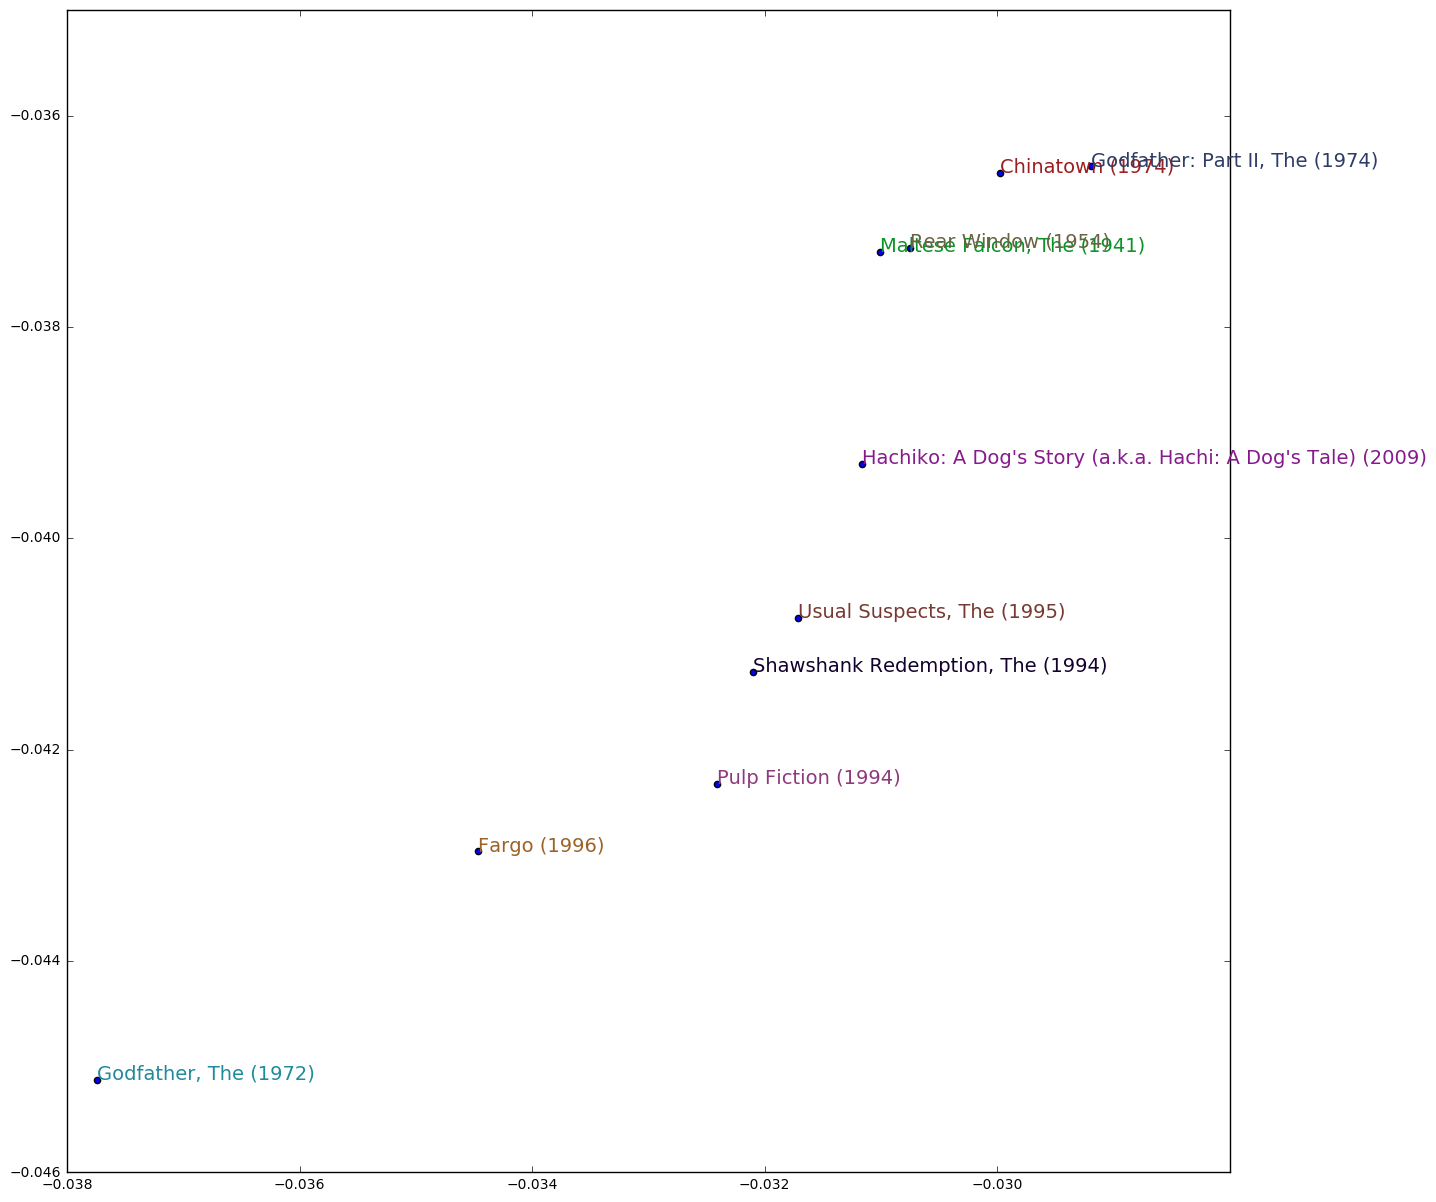

In [111]:
x_min = -0.038
x_max = -0.028
y_min = -0.046
y_max = -0.035

plt.figure(figsize=(15,15))
plt.scatter(X_plot, Y_plot)
for i, x, y in zip(df_Xr.popularity_id, X_plot, Y_plot):
    if (x > x_min and x < x_max and y > y_min and y < y_max):
        plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

Movies seen at the bottom-left (over several iterations):
- The Godfather
- The Godfather: Part II
- Fargo
- Happiness
- The African Queen
- The Lord of Rings: The Fellowship of the Ring
- The Shawshank Redemption
- Ghost in the Shell
- Trainspotting
- Amadeus
- The Usual Suspects
- Memento
- Modern Times
- Cinema Paradiso
- The Conversation
- Pulp Fiction
- Hachiko: A Dog's Story
- The Maltese Falcon
- Rear Window
- Chinatown

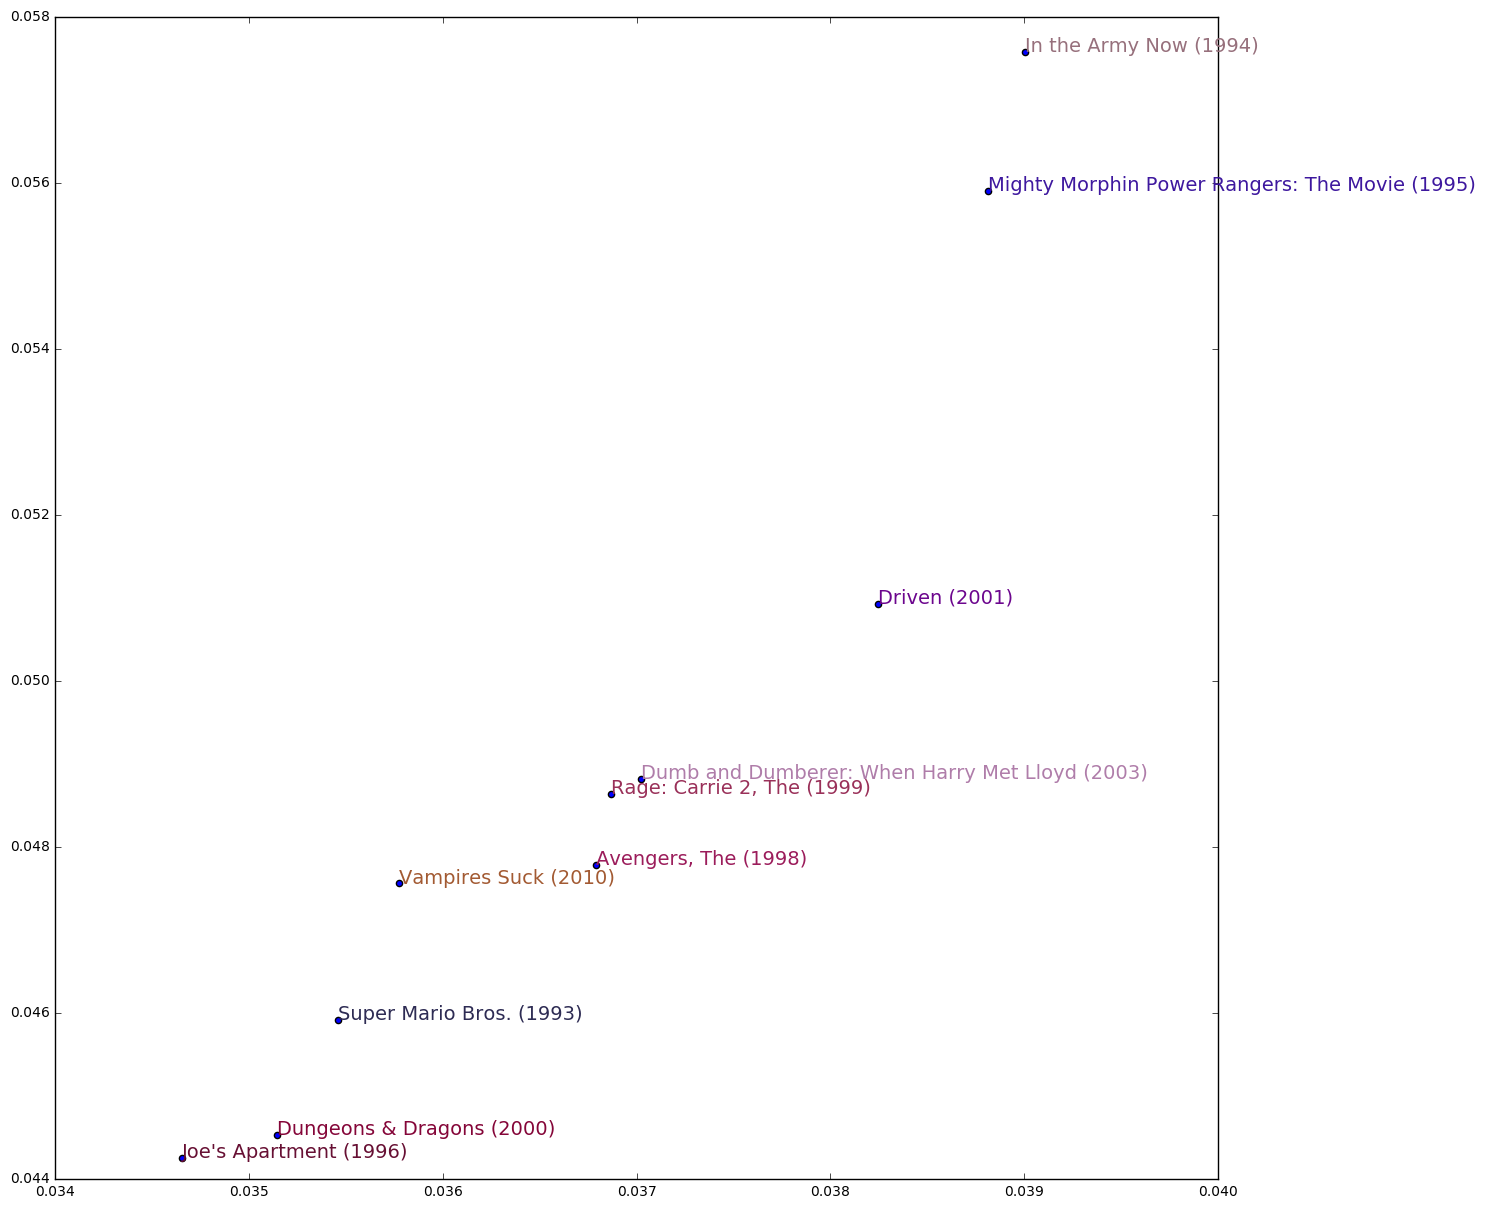

In [115]:
x_min = 0.034
x_max = 0.04
y_min = 0.044
y_max = 0.058

plt.figure(figsize=(15,15))
plt.scatter(X_plot, Y_plot)
for i, x, y in zip(df_Xr.popularity_id, X_plot, Y_plot):
    if (x > x_min and x < x_max and y > y_min and y < y_max):
        plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

Movies seen at the top-right (over several iterations):
- Battlefield Earth
- Speed 2: Cruise Control
- The Wedding Planner
- Vampire in Brooklyn
- Spice World
- Anaconda
- House on Haunted Hill
- Police Academy 3: Back in Training
- Mighty Morphin Power Rangers: The Movie
- Police Academy 5: Assignment: Miami Beach
- After Earth
- Kung Pow: Enter the Fist
- Disaster Movie
- Howard the Duck
- Turbo: A Power Rangers Movie
- Spy Kids 3-D: Game Over
- Driven
- Mighty Morphin Power Rangers: The Movie
- Joe's Apartment
- Dungeons & Dragons
- Super Mario Bros.
- Vampires Suck
- The Avengers
- The Rage: Carrie 2
- Dumb and Dumberer: When Harry Met Lloyd

Finally, let's zoom in on the middle cluster, for good measure.

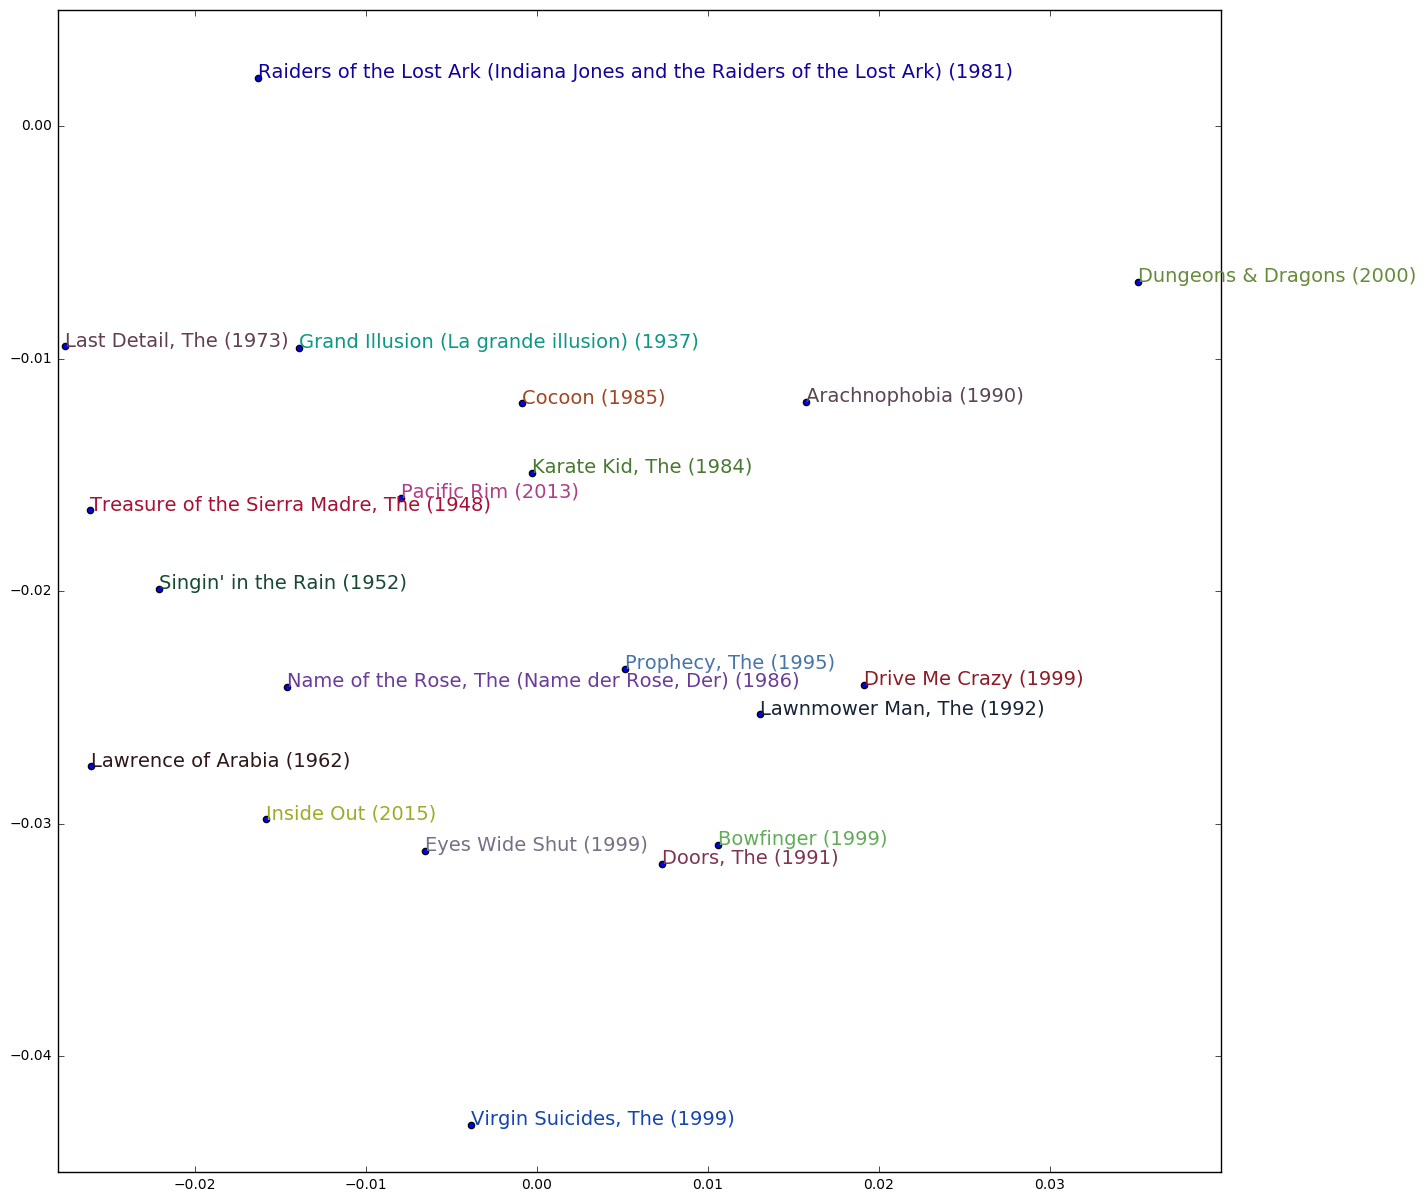

In [117]:
x_min = -0.028
x_max = 0.04
y_min = -0.045
y_max = 0.005

plt.figure(figsize=(15,15))
plt.scatter(X_plot, Y_plot)
for i, x, y in zip(df_Xr.popularity_id, X_plot, Y_plot):
    if (x > x_min and x < x_max and y > y_min and y < y_max):
        plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

If I'm right about these plots being measures of 'critical acclaim' versus 'realism' - then the more realistic a movie, the more critically acclaimed it tends to be, and vice versa!